# Домашнее задание «Элементарные методы анализа временных рядов»

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
# Подключим библиотеки

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [47]:
# Первый ряд
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']

In [48]:
# Фунция визуализации ряда и коррелограммы

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

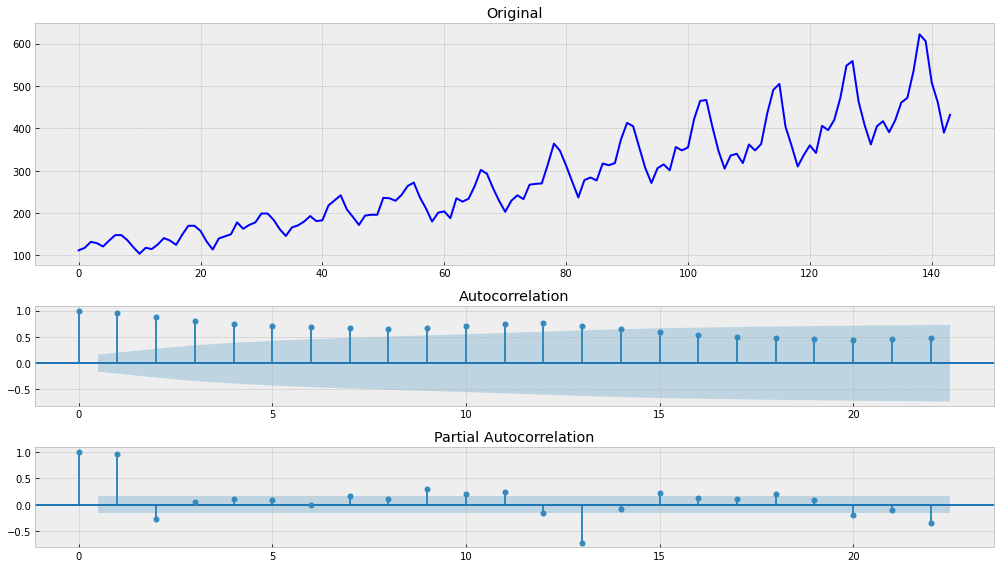

In [49]:
tsplot(series)

Ряд с ярковыраженными трендом и сезонностью. Поэтому используем тройное экспоненциальное сглаживание - оно как раз хорошо работает когда имеется тренд и сезонность.

In [50]:
# Функция задания тренда

def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [51]:
# Функция задания сезонность

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [52]:
# Функция тройного экспоненциального метода

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [53]:
# Функция визуализации

def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

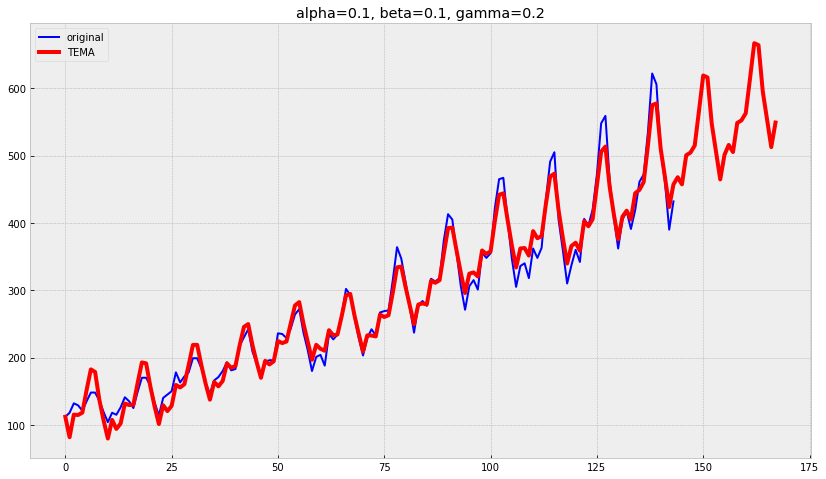

In [54]:
plot_tema(0.1, 0.1, 0.2)

Видно что приближение достаточно точно попало в реально значения и хорошо далее его прогнозирует, сохраняя тренд и сезонность

In [55]:
# Посчитаем ошибку

from sklearn.metrics import mean_squared_error

# Функция MSE
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [59]:
# Получим обучаемую и тестовую выборки

train, test = series[:100], series[100:]

In [60]:
# Посчитаем RMSE

from math import sqrt

print(sqrt(mse((0.1, 0.1, 0.2))))

38.34971136711313


### Вывод
Не знаю большая эта ошибка или нет. На мой взгляд ошибка достаточно большая. Но опять же глядя как приближение попадает в реальные значения - может и нет

In [61]:
# Второя ряд - стационарный

series = pd.read_csv("Series/daily-total-female-births-in-cal.csv")['Count']

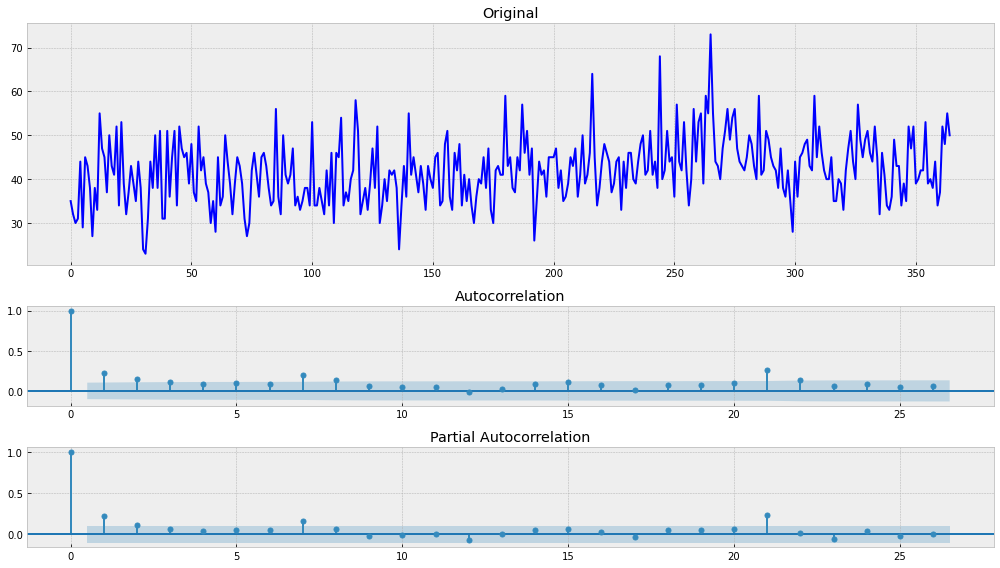

In [62]:
tsplot(series)

Разброс очень сильный - попробуем приблизить скользящим средним и получить наметки тренда.

In [63]:
# Функция скользящего среднего

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

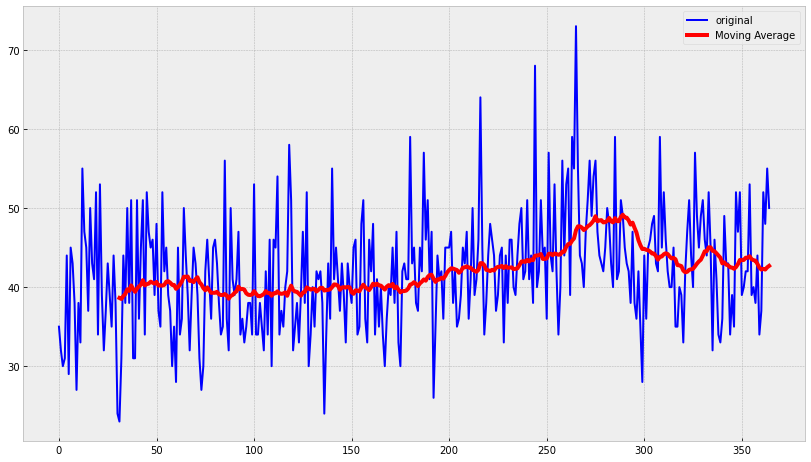

In [69]:
# Визуализируем приближение

ser = moving_average(series, 32)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Посчитаем качество

In [71]:
# Тестовые и обучаемые выборки

train, test = series[:300], series[300:]

In [72]:
# Получим RMSE

print(sqrt(mse((0.1, 0.1, 0.2))))

29.189234386962397


### Выводы:
Получилось даже меньше чем у первого ряда, но возможно что для текущего ряда ошибка даже более значимая чем у первого.